<center><h1>ResNet 18 Model Trainer <center>

Training label distribution:
label
0    62
1    62
Name: count, dtype: int64


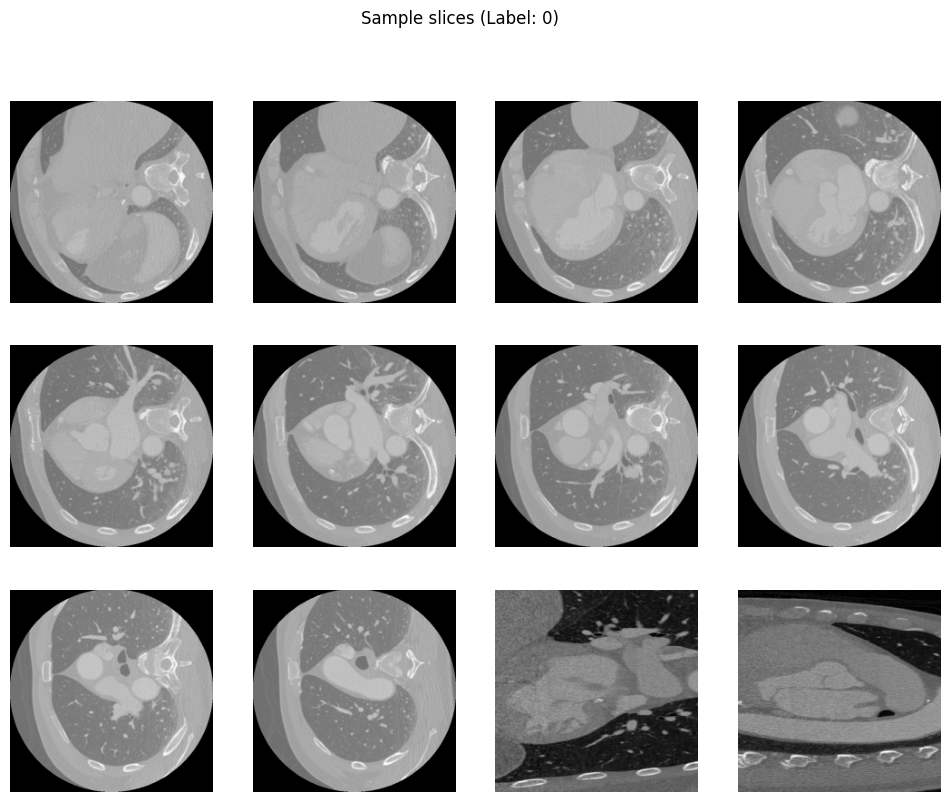

c:\Users\HenryLi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HenryLi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Classifier weights stats (pre-epoch):
  Mean: 0.0009409113554283977
  Std: 0.051610011607408524


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Feature Vector Mean: -0.057129744440317154 Std: 0.5663742423057556
Feature Vector Mean: -0.05990688130259514 Std: 0.5800772905349731
Feature Vector Mean: -0.06246086210012436 Std: 0.5844508409500122
Feature Vector Mean: -0.06520042568445206 Std: 0.6258528828620911
Feature Vector Mean: -0.06629202514886856 Std: 0.6363291144371033
Feature Vector Mean: -0.07116392254829407 Std: 0.6884171366691589
Feature Vector Mean: -0.07451748847961426 Std: 0.7354971766471863
Feature Vector Mean: -0.07814313471317291 Std: 0.7568771839141846
Feature Vector Mean: -0.08133232593536377 Std: 0.8125088214874268
Feature Vector Mean: -0.08669136464595795 Std: 0.8538551330566406
Feature Vector Mean: -0.0911596491932869 Std: 0.898283064365387


KeyboardInterrupt: 

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import nibabel as nib
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import clear_output
import seaborn as sns
import pydicom
import pathlib
import torchvision.models as models

# ----------------------------
# Data loading and preprocessing
# ----------------------------
class CTADataset(Dataset):
    def __init__(self, labels_csv, root_dir, transform=None):
        self.data = pd.read_csv(labels_csv)
        self.root_dir = root_dir
        self.transform = transform
        self.data['label'] = self.data['label'].apply(lambda x: 1 if x >= 3 else 0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data.iloc[idx]
        filename = entry['filename']
        scan_id = filename.split('-')[1].split()[0]
        file_path = os.path.join(self.root_dir, scan_id, '20', filename)
        volume = load_scan(file_path)
        volume = normalize_volume(volume)
        slices = extract_12_slices(volume)
        slices = torch.tensor(slices).unsqueeze(1).float()
        label = torch.tensor(entry['label']).float()
        return slices, label

# ----------------------------
# Scan loading functions
# ----------------------------
def load_scan(file_path):
    file_path = str(pathlib.Path(file_path))
    if file_path.endswith('.nii') or file_path.endswith('.nii.gz'):
        img = nib.load(file_path)
        return img.get_fdata()
    elif os.path.isdir(file_path):
        slices = [pydicom.dcmread(os.path.join(file_path, f)) for f in os.listdir(file_path) if f.endswith('.dcm')]
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        volume = np.stack([s.pixel_array for s in slices], axis=-1)
        return volume
    else:
        raise ValueError(f"Unsupported format or bad path: {file_path}")

def normalize_volume(volume):
    volume = volume.astype(np.float32)
    volume -= np.min(volume)
    volume /= np.max(volume)
    return volume

def extract_12_slices(volume):
    slices = []
    z_len = volume.shape[2]
    axial_indices = np.linspace(0, z_len - 1, 10, dtype=int)
    axial_slices = [volume[:, :, idx] for idx in axial_indices]
    coronal_idx = volume.shape[1] // 2
    coronal_slice = volume[:, coronal_idx, :]
    sagittal_idx = volume.shape[0] // 2
    sagittal_slice = volume[sagittal_idx, :, :]
    slices.extend(axial_slices)
    slices.append(coronal_slice)
    slices.append(sagittal_slice)
    resized = [cv2.resize(s, (224, 224), interpolation=cv2.INTER_AREA) for s in slices]
    return np.stack(resized, axis=0)

# ----------------------------
# Model Definition
# ----------------------------
class SliceCNN(nn.Module):
    def __init__(self, feature_dim=128):
        super(SliceCNN, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(512, feature_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class CTAQuality2D(nn.Module):
    def __init__(self, feature_dim=128):
        super(CTAQuality2D, self).__init__()
        self.slice_cnn = SliceCNN(feature_dim)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, S, C, H, W = x.shape
        x = x.view(B * S, C, H, W)
        feats = self.slice_cnn(x)
        feats = feats.view(B, S, -1)
        pooled = feats.mean(dim=1)
        print("Feature Vector Mean:", pooled.mean().item(), "Std:", pooled.std().item())
        out = self.classifier(pooled)
        return out.squeeze(1)

# ----------------------------
# Training and Evaluation
# ----------------------------
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds.append(outputs.cpu())
            targets.append(labels.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return total_loss / len(dataloader.dataset), preds, targets

# ----------------------------
# Training Driver
# ----------------------------
root_dir = "C:\\Users\\HenryLi\\Downloads\\Scans"
labels_csv = "C:/Users/HenryLi/Desktop/Python Projects/CTA Scan Binary Classifier/Labels.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
num_epochs = 10

# Stratified split
df = pd.read_csv(labels_csv)
df['label'] = df['label'].apply(lambda x: 1 if x >= 3 else 0)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)

# Print label distribution for debugging
print("Training label distribution:")
print(train_df['label'].value_counts())

# Oversample minority class using WeightedRandomSampler
class_sample_counts = train_df['label'].value_counts().to_dict()
weights = train_df['label'].apply(lambda x: 1.0 / class_sample_counts[x])
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_dataset = CTADataset('train.csv', root_dir)
val_dataset = CTADataset('val.csv', root_dir)

# Visual check on sample slices from the training set
sample_slices, sample_label = train_dataset[0]
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_slices[i, 0], cmap='gray')
    ax.axis('off')
plt.suptitle(f'Sample slices (Label: {int(sample_label.item())})')
plt.show()

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = CTAQuality2D().to(device)
pos_weight = torch.tensor([2.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()

    # 🔍 Check classifier weights before training
    print("Classifier weights stats (pre-epoch):")
    print("  Mean:", model.classifier[0].weight.data.mean().item())
    print("  Std:", model.classifier[0].weight.data.std().item())

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_preds, val_targets = evaluate(model, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    preds_bin = (val_preds.numpy() > 0.5).astype(int)
    targets_bin = val_targets.numpy().astype(int)
    acc = accuracy_score(targets_bin, preds_bin)
    f1 = f1_score(targets_bin, preds_bin, zero_division=0)

    #Optional: Checking feature vector std on a batch
    with torch.no_grad():
        model.eval()
        sample_inputs, _ = next(iter(val_loader))
        sample_inputs = sample_inputs.to(device)
        B, S, C, H, W = sample_inputs.shape
        flat_inputs = sample_inputs.view(B * S, C, H, W)
        feats = model.slice_cnn(flat_inputs)
        feats = feats.view(B, S, -1)
        pooled = feats.mean(dim=1)
        print("Feature vector mean:", pooled.mean().item())
        print("Feature vector std:", pooled.std().item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_resnet18model.pt')

    # Visualization
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    print("Predicted label distribution:", np.unique(preds_bin, return_counts=True))
    print("True label distribution:", np.unique(targets_bin, return_counts=True))
    print(f"Val Accuracy: {acc:.3f}, F1 Score: {f1:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(targets_bin, preds_bin)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Logit histogram
    plt.figure(figsize=(8, 4))
    plt.hist(val_preds.numpy(), bins=30, color='gray', edgecolor='black')
    plt.title('Validation Logit Distribution')
    plt.xlabel('Logit')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Threshold tuning
    best_f1 = 0
    best_threshold = 0.5
    for thresh in np.linspace(0.1, 0.9, 17):
        preds_thresh = (val_preds.numpy() > thresh).astype(int)
        f1_thresh = f1_score(targets_bin, preds_thresh, zero_division=0)
        if f1_thresh > best_f1:
            best_f1 = f1_thresh
            best_threshold = thresh

    print(f"Best Threshold: {best_threshold:.2f} (F1: {best_f1:.3f})")

print("Sample Predictions vs Targets:")
for pred, target in zip(val_preds[:10], val_targets[:10]):
    print(f"Pred (logit): {pred.item():.2f}, Target: {target.item():.0f}")
